In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import sklearn

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

sys.path.append('./../')
from src.dataset import VehiclePredictorDataset
from src.utils import train_model, evaluate_model, get_model, visualize_model

/nethome/aprabakaran3/miniconda3/envs/dl_proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GPU Check

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Config Variables

In [3]:
root_path = './../'
data_path = os.path.join(root_path, 'data')
dataset_path = os.path.join(data_path, 'VMMRdb')

# modify this line if you want to train a model on top 100/top 200/top 300 most common make_models
with open(os.path.join(data_path, 'make_model_most_common_300.pkl'), 'rb') as f:
    target_make_model_labels = pickle.load(f)

# load the dataset for some stats
vp_dataset = VehiclePredictorDataset(root_dir=dataset_path, target_make_model_labels=target_make_model_labels)
num_images = len(vp_dataset)
num_labels = len(vp_dataset.make_model_counts)
class_distribution = vp_dataset.make_model_counts
print(f"num_images: {num_images}")
print(f"num_labels: {num_labels}")

num_images: 254784
num_labels: 300


## Define the transforms
- Add other transforms here later, if needed. 
- Do we need any specific transforms for train and val?

In [4]:
def get_transform():
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return transform

## Instantiate the train, val and test dataloaders

In [5]:
train_split_ratio = 0.8
val_split_ratio = 0.1
test_split_ration = 0.1

# later see if you can have train-specific transforms
dataset = VehiclePredictorDataset(root_dir=dataset_path, target_make_model_labels=target_make_model_labels, transform=get_transform())

# split dataset in train and val set
dataset_len = len(dataset)
indices = torch.randperm(dataset_len).tolist()
train_split_index = int(train_split_ratio * dataset_len)
val_split_index = train_split_index + int(val_split_ratio * dataset_len)
train_dataset = torch.utils.data.Subset(dataset, indices[0:train_split_index])
val_dataset = torch.utils.data.Subset(dataset, indices[train_split_index:val_split_index])
test_dataset = torch.utils.data.Subset(dataset, indices[val_split_index:])

# define the dataloaders
dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

dataloader_val = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=1,
)

dataloader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
)

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(val_dataset)
}

print(f'train: 0 to {train_split_index}\nval: {train_split_index} to {val_split_index}\ntest: {val_split_index} to {dataset_len-1}')
print(f'dataset_sizes : {dataset_sizes}')

train: 0 to 203827
val: 203827 to 229305
test: 229305 to 254783
dataset_sizes : {'train': 203827, 'val': 25478, 'test': 25478}


## Model config

In [6]:
# check https://pytorch.org/vision/0.8/models.html to experiment with other backbone model
backbone_model = 'mobilenet_v2'
num_epochs = 10

# get the model
model = get_model(num_labels, backbone_model).to(device)

# the reason for computing weights is to account for the class imbalance
weight_distribution = 1 / torch.tensor(list(class_distribution.values()))
weight_distribution = weight_distribution / weight_distribution.sum()
weight_distribution = weight_distribution.to(device)

# define the loss function
criterion = nn.CrossEntropyLoss(weight=weight_distribution)

# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# define the scheduler
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_info = {
    'backbone': backbone_model,
    'num_classes': f"{num_labels}classes",
    'num_epochs': f"{num_epochs}epochs",
}

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /nethome/aprabakaran3/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 47.5MB/s]


## Train
- Uncomment this line if you want to train again. 
- The trained models are all stored in this [drive folder]( https://drive.google.com/drive/folders/1RXaKgStTFnVRaLvk-eIHEGhwvQp-y1-c?usp=sharing)

In [7]:
train_model(model, model_info, dataset_sizes, dataloader_train, dataloader_val, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 12740/12740 [13:05<00:00, 16.22it/s]


train Loss: 3.6172 Acc: 0.2182 Time: 786m 786s


100%|██████████| 1593/1593 [01:37<00:00, 16.38it/s]


val Loss: 1.9195 Acc: 0.4659 Time: 883m 883s
Epoch 1/9
----------


100%|██████████| 12740/12740 [13:16<00:00, 15.99it/s]


train Loss: 1.6455 Acc: 0.5303 Time: 1680m 1680s


100%|██████████| 1593/1593 [01:36<00:00, 16.53it/s]


val Loss: 1.2056 Acc: 0.6308 Time: 1776m 1776s
Epoch 2/9
----------


100%|██████████| 12740/12740 [13:14<00:00, 16.04it/s]


train Loss: 1.1210 Acc: 0.6437 Time: 2570m 2570s


100%|██████████| 1593/1593 [01:36<00:00, 16.45it/s]


val Loss: 0.9312 Acc: 0.6982 Time: 2667m 2667s
Epoch 3/9
----------


100%|██████████| 12740/12740 [13:15<00:00, 16.02it/s]


train Loss: 0.8629 Acc: 0.7041 Time: 3463m 3463s


100%|██████████| 1593/1593 [01:42<00:00, 15.47it/s]


val Loss: 0.8002 Acc: 0.7323 Time: 3566m 3566s
Epoch 4/9
----------


100%|██████████| 12740/12740 [13:29<00:00, 15.75it/s]


train Loss: 0.7092 Acc: 0.7418 Time: 4375m 4375s


100%|██████████| 1593/1593 [01:36<00:00, 16.43it/s]


val Loss: 0.7279 Acc: 0.7592 Time: 4472m 4472s
Epoch 5/9
----------


100%|██████████| 12740/12740 [13:06<00:00, 16.19it/s]


train Loss: 0.5980 Acc: 0.7700 Time: 5259m 5259s


100%|██████████| 1593/1593 [01:36<00:00, 16.45it/s]


val Loss: 0.6956 Acc: 0.7704 Time: 5355m 5355s
Epoch 6/9
----------


100%|██████████| 12740/12740 [13:17<00:00, 15.97it/s]


train Loss: 0.5128 Acc: 0.7931 Time: 6153m 6153s


100%|██████████| 1593/1593 [01:37<00:00, 16.40it/s]


val Loss: 0.6432 Acc: 0.7821 Time: 6250m 6250s
Epoch 7/9
----------


100%|██████████| 12740/12740 [13:11<00:00, 16.10it/s]


train Loss: 0.4512 Acc: 0.8105 Time: 7041m 7041s


100%|██████████| 1593/1593 [01:38<00:00, 16.13it/s]


val Loss: 0.6361 Acc: 0.7845 Time: 7140m 7140s
Epoch 8/9
----------


100%|██████████| 12740/12740 [13:11<00:00, 16.10it/s]


train Loss: 0.3990 Acc: 0.8244 Time: 7932m 7932s


100%|██████████| 1593/1593 [01:38<00:00, 16.23it/s]


val Loss: 0.6311 Acc: 0.7918 Time: 8030m 8030s
Epoch 9/9
----------


100%|██████████| 12740/12740 [13:13<00:00, 16.06it/s]


train Loss: 0.3567 Acc: 0.8385 Time: 8823m 8823s


100%|██████████| 1593/1593 [01:38<00:00, 16.20it/s]


val Loss: 0.5941 Acc: 0.8117 Time: 8922m 8922s
Training complete in 148m 42s
Best val Acc: 0.811681


## Evaluate on test set

In [8]:
# Load saved model
model_name = 'mobilenet_v2_300classes_10epochs.pth'
backbone_model = 'mobilenet_v2'
model = get_model(num_labels, backbone_model).to(device)
model.load_state_dict(torch.load(os.path.join(root_path, 'models', model_name)))

cm, cr = evaluate_model(model, dataset_sizes, dataloader_test, target_make_model_labels)

# plot the CM
cm_pd = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_pd = pd.DataFrame(cm_pd, index=target_make_model_labels, columns=target_make_model_labels)
cr_pd = pd.DataFrame(cr).transpose()

100%|██████████| 25479/25479 [05:06<00:00, 83.04it/s]


Test Acc: 0.8133
Average time per image: 0.0120 seconds


- Confusion matrix

In [9]:
cm_pd

,honda_civic,honda_accord,ford_mustang,toyota_camry,chevrolet_silverado,nissan_altima,ford_f150,ford_explorer,chevrolet_impala,toyota_corolla,...,ford_contour,toyota_pickup,acura_rdx,infiniti_qx56,chevrolet_bel air,chevrolet_el camino,hummer_h3,lincoln_aviator,mazda_5,acura_cl
honda_civic,0.722222,0.000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000,0.000000,0.0,0.0000
honda_accord,0.000000,0.496,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.008,0.00000,0.000000,0.000000,0.0,0.0000
ford_mustang,0.000000,0.000,0.848485,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000,0.000000,0.0,0.0000
toyota_camry,0.000000,0.000,0.000000,0.98374,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000,0.000000,0.0,0.0000
chevrolet_silverado,0.000000,0.000,0.000000,0.00000,0.973684,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000,0.000000,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chevrolet_el camino,0.000000,0.000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.008547,...,0.0,0.0,0.0,0.0,0.000,0.91453,0.000000,0.000000,0.0,0.0000
hummer_h3,0.000000,0.000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000,0.00000,0.870968,0.000000,0.0,0.0000
lincoln_aviator,0.000000,0.000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000,0.966667,0.0,0.0000
mazda_5,0.000000,0.000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000,0.000000,1.0,0.0000


- Classification Report

In [10]:
cr_pd

,precision,recall,f1-score,support
honda_civic,0.481481,0.722222,0.577778,18.000000
honda_accord,0.805195,0.496000,0.613861,125.000000
ford_mustang,1.000000,0.848485,0.918033,33.000000
toyota_camry,0.991803,0.983740,0.987755,123.000000
chevrolet_silverado,0.755102,0.973684,0.850575,38.000000
...,...,...,...,...
mazda_5,0.892857,1.000000,0.943396,25.000000
acura_cl,0.709677,0.687500,0.698413,32.000000
accuracy,0.813297,0.813297,0.813297,0.813297
macro avg,0.781383,0.835400,0.794257,25479.000000


- Save/Load the metrics

In [11]:
cm_pd.to_csv(os.path.join(root_path, 'results', 'baseline_methods', f"confusion_matrix_{model_name}.csv"), index=False)
cr_pd.to_csv(os.path.join(root_path, 'results', 'baseline_methods', f"classification_report_{model_name}.csv"), index=False)
#cm_pd_df = pd.read_csv(os.path.join(root_path, 'results', 'baseline_methods', f"confusion_matrix_{model_name}.csv"))
#cr_pd_df = pd.read_csv(os.path.join(root_path, 'results', 'baseline_methods', f"classification_report_{model_name}.csv"))

## Visually Inspect performance
- Load a target model to inpect

In [12]:
# Load saved model
model = get_model(num_labels, backbone_model).to(device)
model.load_state_dict(torch.load(os.path.join(root_path, 'models', model_name)))

<All keys matched successfully>

- Visualize for a few examples from the test set

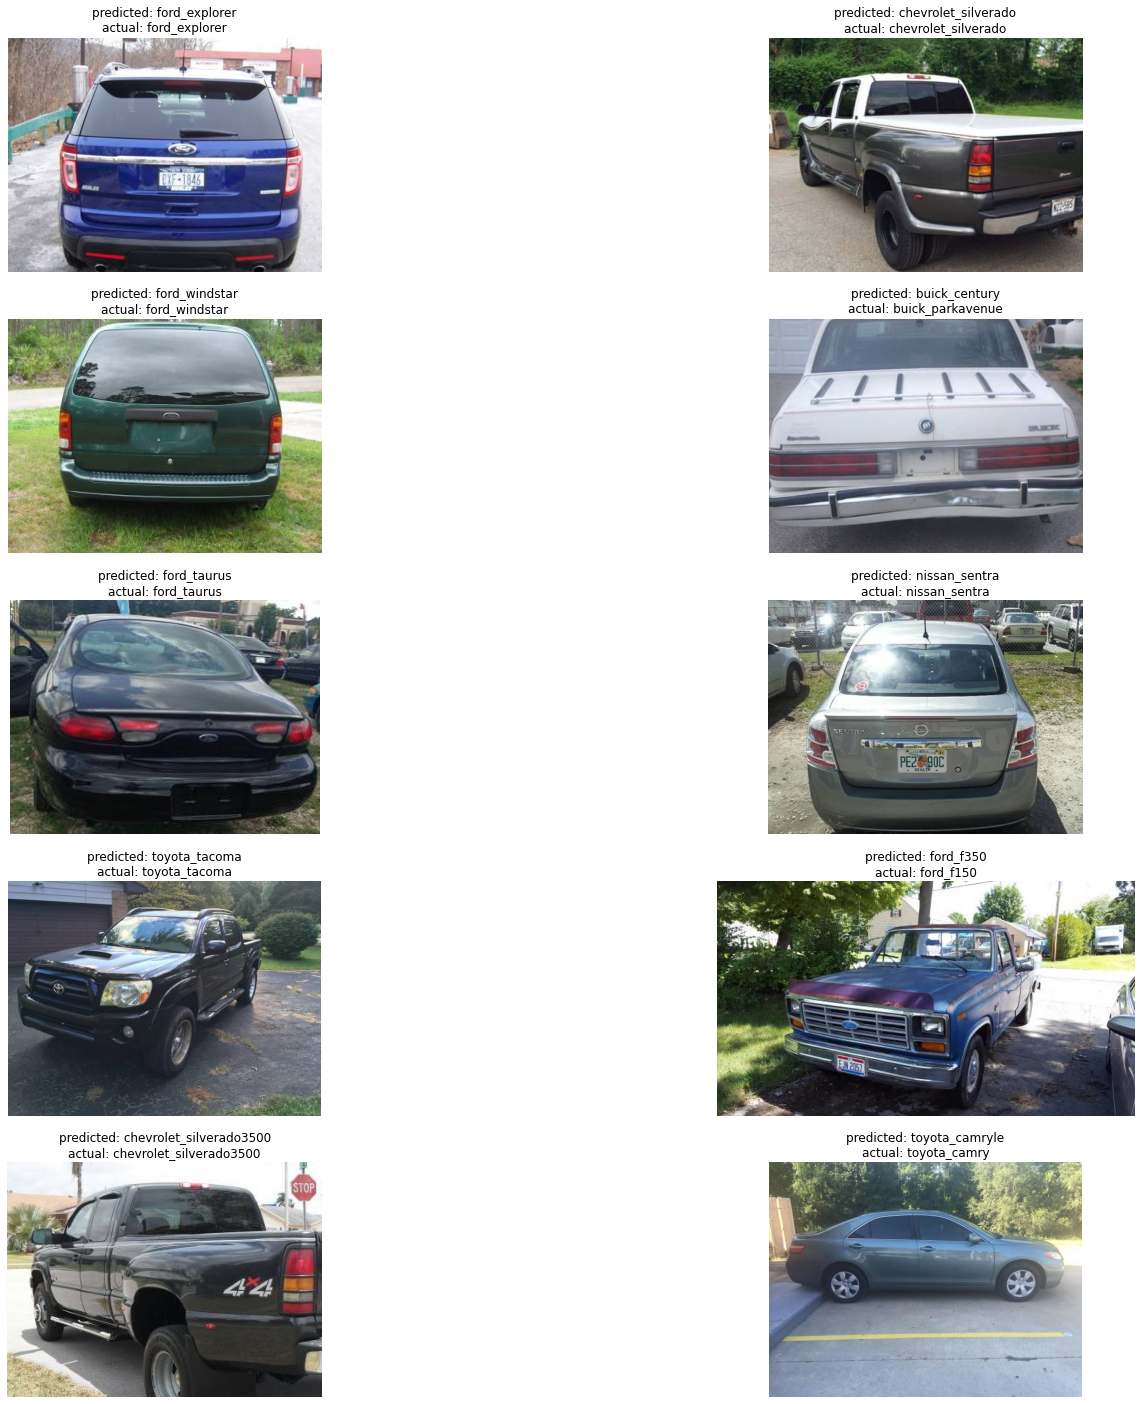

In [13]:
visualize_model(model, dataset, dataloader_test, target_make_model_labels, num_images=10)